In [ ]:
import sys
sys.version

'3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:00:33) \n[Clang 13.0.1 ]'

In [23]:
import tensorflow as tf

print(
    f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}"
)
print(f"TensorFlow version: {tf.__version__}")

TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.9.1


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import seaborn as sns
import os
import pickle
import random

# Import data

In [20]:
# Tureky soil samples are the soils starting with 'no' 1000 or above
data = pd.read_csv('data.csv') \
            .drop('hhpa', axis=1)
data['VWC'] = data['VWC']/100
print(data.shape) 
data.head()

(20383, 9)


,fold,no,clay,silt,sand,BD,omc,pF,VWC
0,1,55,32.6,43.3,24.1,1.14,4.50,0.841595,0.558
1,1,97,19.8,67.0,13.2,1.14,3.56,1.069393,0.487
2,1,166,27.7,41.6,30.7,1.15,3.00,2.057260,0.394
3,1,1015,45.7,30.4,24.0,0.85,0.49,1.360000,0.620
4,1,1066,13.5,25.5,61.0,1.23,1.27,2.690000,0.250


## EDA

In [ ]:
data.groupby('fold').count()

In [ ]:
plt.figure(figsize=(18, 10))
sns.boxplot(data=data.iloc[:, 2:])
plt.show()

In [ ]:
data.describe()

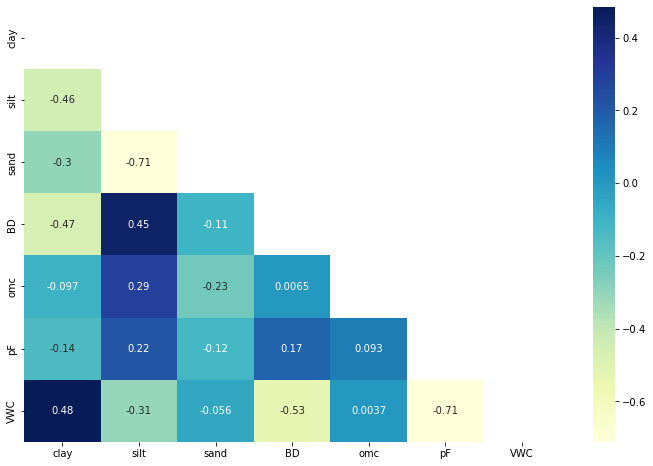

In [7]:
sns.reset_orig()
plt.figure(figsize=(12,8))
corr = data.iloc[:, 2:].corr()
# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr)

sns.heatmap(corr, annot = True, mask=matrix,cmap="YlGnBu")
plt.show()

# Defining functions

In [19]:
# from keras_tuner.tuners import RandomSearch 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
# # Make directory for storing saved models
# os.makedirs('model4')

## Define the `bagging` function

In [ ]:
def bagging(rawdata):
    """Take bootstrap samples - sampling with replacement"""
    ###generator random sample id with replacement
    idx = pd.DataFrame(rawdata[['no']])
    idx_rmdup = idx.drop_duplicates()
    length = len(idx_rmdup)
    samples = idx_rmdup.sample(length, replace= True)
    # changing the sample id into one dimensional list in order to label sampleid in idx 
    samples_list = samples.transpose().values.tolist()[0] 
    ###going through the sampleid dataframe and marking the sample as training or validation dataset. 
    idx['labels'] = ['training' if x in samples_list else 'validation'  for x in idx['no'] ]
    rawdata_con = pd.concat([rawdata,idx['labels']],axis = 1)
    ###spliting rawdata into training and validation based on label column 
    grouped_rawdata = rawdata_con.groupby('labels')
    training = grouped_rawdata.get_group('training')
    validation = grouped_rawdata.get_group('validation')
    return training,validation

## `build_model` function

In [ ]:
def build_model(hp):
    """Build and compile the NN model"""
    model = tf.keras.Sequential([
       tf.keras.layers.Dense(
                        units=hp.Int('units',
                        min_value=2,
                        max_value=14,
                        step=1),
                        activation=hp.Choice("activation", ["relu", "tanh"])
                        ),
        tf.keras.layers.Dense(units=1)
        ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(),
            loss='mse',
            metrics=['mae'])
    return model

## Define `wettodry` and `drytowet` functions

In [3]:
def wettodry(vwc):
    vwc = [0 if i < 0 else i for i in vwc]
    w2d = [vwc[0]]
    for idx in range(1, len(vwc)):
        if vwc[idx] < w2d[idx-1]:
            w2d.append(vwc[idx])
        else:
            w2d.append(w2d[idx-1])
    return w2d

def drytowet(vwc):
    vwc = [0 if i < 0 else i for i in vwc]
    rslt_reverse = vwc[::-1]
    d2w = [rslt_reverse[0]]
    for idx in range(1, len(vwc)):
        if rslt_reverse[idx] > d2w[idx-1]:
            d2w.append(rslt_reverse[idx])
        else:
            d2w.append(d2w[idx-1])
    return d2w[::-1]

## Define `bag_predict`
and return mean and standard deviations

In [4]:
def bag_predict(models, X_test):
    bag_pred = pd.DataFrame()
    for ann in models:
        # print(ann)
        ann_all = tf.keras.models.load_model(ann)
        y_pred = ann_all.predict(X_test)
        w2d = wettodry(y_pred.ravel().tolist())
        d2w = drytowet(y_pred.ravel().tolist())
        # print(w2d==d2w)
        pred_list = [(g + h) / 2 for g, h in zip(w2d, d2w)]
        bag_pred[ann[ann.find('ann'):-3]] = pd.Series(pred_list)

    mean_vwc = bag_pred.mean(axis=1)
    std_vwc = bag_pred.std(axis=1)
    return mean_vwc, std_vwc

# Bootstrap (finding and fitting best models)

In [ ]:
losses = {}

iteration = 100
for bb in range(iteration):
    training, validation = bagging(data)
    ## MODEL 1
    # X_train = training.iloc[:,2:-2]
    # X_valid = validation.iloc[:,2:-2]
    ## MODEL 2
    # X_train = training.loc[:,['clay', 'silt', 'sand','pF']]
    # X_valid = validation.loc[:,['clay', 'silt', 'sand','pF']]
    ## MODEL 3
    # X_train = training.loc[:,['clay', 'silt', 'sand','BD', 'pF']]
    # X_valid = validation.loc[:,['clay', 'silt', 'sand', 'BD', 'pF']]
    ## MODEL 4
    X_train = training.loc[:,['clay', 'silt', 'sand','omc', 'pF']]
    X_valid = validation.loc[:,['clay', 'silt', 'sand', 'omc', 'pF']]

    y_train = training.iloc[:,-2]
    y_valid = validation.iloc[:,-2]

    # scaler = MinMaxScaler() 
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)

    tuner = RandomSearch(
        build_model,    
        objective='val_loss',
        max_trials=5,
        executions_per_trial=1,
        overwrite=True,
        directory='project',
        project_name='HPtuning_'+str(bb))

    early_stop = [tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                    patience=4,
                    restore_best_weights=True)]

    tuner.search(X_train, y_train,
                epochs=25,
                validation_data=(X_valid, y_valid),
                callbacks=early_stop,
                verbose=2)

    print(f"Fitting the best model for iteration {bb+1}......." "\n"
            f"Training Size = {len(training)}, validation Size = {len(validation)}" "\n"
            f"Unique soils in Training = {len(training.no.unique())}" "\n"
            f"Unique soils in Validation = {len(validation.no.unique())}" "\n"
            f"INPUT SHAPE: {X_train.shape[1]}")

    best_hps = tuner.get_best_hyperparameters(2)
    model = build_model(best_hps[0])

    callback = [tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                    patience=15,
                    restore_best_weights=True),
                tf.keras.callbacks.ModelCheckpoint(filepath="model4/ann_"+str(bb)+".h5",
                    monitor="val_loss",
                    save_best_only=True)]
    # use `model.fit()` here to train and save the best model from `tuner.search`
    history = model.fit(X_train, y_train,
                batch_size = 32, epochs = 500,
                callbacks=callback,
                validation_data=(X_valid, y_valid),
                verbose=0)
    losses[bb] = history.history
    print(f"Activation function --- {model.layers[0].activation}""\n"
        f"Number of hidden neurons = {model.layers[0].units}")
    print("Done")

In [ ]:
with open('history_4.pkl', 'wb') as handle:
    pickle.dump(losses, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
models = ['model4/ann_'+ str(i) + '.h5' for i in range(100)]
hidden_n, activation_fn = [] ,[]
for ann in models:
    model = tf.keras.models.load_model(ann)
    print(model.layers[0].activation, model.layers[0].units)
    # hidden_n.append(model.layers[0].units), activation_fn.append(model.layers[0].activation)

## Save Scaler

In [ ]:
##MODEL 1
scaler = StandardScaler()
scaler.fit_transform(data.iloc[:, 2:-1])
pickle.dump(scaler, open("ann1_stdscaler.pkl", "wb"))

##MODEL 2
scaler = StandardScaler()
scaler.fit_transform(data.loc[:, ["clay", "silt", "sand", "pF"]])
pickle.dump(scaler, open("ann2_stdscaler.pkl", "wb"))

## MODEL 3
scaler = StandardScaler()
scaler.fit_transform(data.loc[:, ["clay", "silt", "sand", "BD", "pF"]])
pickle.dump(scaler, open("ann3_stdscaler.pkl", "wb"))

## MODEL 4
scaler = StandardScaler()
scaler.fit_transform(data.loc[:, ["clay", "silt", "sand", "omc", "pF"]])
pickle.dump(scaler, open("ann4_stdscaler.pkl", "wb"))

# Predict

## Import data and apply Scaler

In [ ]:
file = os.path.abspath('PTF3_data.xlsx')

data2 = pd.read_excel(file,'lab')
data2 = data2.head(1016).iloc[:,:17]
data2.columns, data2.shape

In [ ]:
scaler = pickle.load(open('ann2_stdscaler.pkl', 'rb'))

## Create Test data

In [ ]:
def create_Xtest(data):
    """enter the dataframe and this function will return the X_test data"""
    pF = pd.Series(np.arange(-1, 6, 0.05), name='pF')
    df = pd.concat([data.drop_duplicates()]*len(pF), ignore_index=True)
    test = pd.concat([df,pF], axis=1)
    return test

In [ ]:
colList = ['no', 'clay', 'silt', 'sand']
df_group = data[colList].groupby(['no'])
test_all = df_group.apply(create_Xtest)

In [ ]:
rand_soil = random.choice(data.no.unique())
print(rand_soil)
soil_test = test_all[test_all['no']==rand_soil]

X_test = scaler.transform(soil_test.iloc[:,1:])

Have to use `bag_predict` and scaler on each soil individually.
Making predicitons on the entire dataset results in wrong results

## Apply `bag_predict`

In [ ]:
models = ['model2/ann_'+ str(i) + '.h5' for i in range(100)]
mean_vwc, std_vwc = bag_predict(models, X_test)

In [ ]:
result_all = pd.concat([test_all.reset_index(drop=True), pd.Series(mean_vwc, name = 'mean_vwc'),
            pd.Series(std_vwc, name = 'std_vwc')], axis=1)